# Notebook 2 - Synaptic inputs and dendrites

From now on we will import libraries that we already introduced in the first code cell of the notebook. In turn, this means you have to execute it in order for the rest to work properly

In [49]:
# Execute this cell to import all the libraries that we are going to use
# Once imported, you can then use them in every cell in this notebook. The same holds for 
# functions/classes you define or variables you declare (more on that mayne later) 


import matplotlib.pyplot as plt
# Settings for the figures
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")
from ipywidgets import interact
import numpy as np # we will not really use it yet in this notebook

# Synaptic Input to the leaky integrate and fire model

Today we will expand upon the class we developed in the last sessions and incorporate the new features we learned in the lecture.
As a reminder, here is the differential equation that described the membrane potential of our neuron:

\begin{align}
\tau_m\,\frac{dV}{dt} &= - V + E_{L} + R_m\,I_e &\text{if }\quad V(t) \leq V_{th} \\ 
&&\\ 
V(t) &= V_{reset} &\text{otherwise}
\end{align}


where $V$ is the membrane potential, $\tau_m$ is the membrane time constant, $E_{L}$ is the leak potential, $R_m$ is the membrane resistance, $I_e$ is the synaptic input current, $V_{th}$ is the firing threshold, and $V_{reset}$ is the reset voltage.

#### Adding Synaptic inputs
We now want to include synaptic input to our model. One excitatory input (AMPA) and one inhibitory input (GABA A).
As discussed in the lecture we can add the membrane currents in the following fashion:

\begin{align}
\frac{dV}{dt} &= \left(- V + E_{L} + R_m\,I_e  -i_{ampa} - i_{gaba}\right)/\tau_m\ &\text{if }\quad V(t) \leq V_{th} \\ 
\\ 
V(t) &= V_{reset} &\text{otherwise}
\end{align}


### Task  1

Add the syanptic inputs to our class from the previous notebook. We <b>first start with the excitatory input $i_{ampa}$</b>, it follows the same logic as the inhibitory one - adding $i_{gaba}$ is therefore rather straightorward afterwards.

There are a couple of things we want to add now, let's break it down step by step: 

1) We need to consider the equation for synaptic inputs, from the lecture we know that we can fit the excitatory postsynaptic current with an exponential function because $P(s) \propto e^{-\frac{t}{\tau_{ampa}}}$. we already know another implementation of an exponential decay: the voltage membrane. We therefore use the same principle for the implementation of the channel open probaility:

\begin{equation}
\frac{d\,P_s}{d\,t} = - \frac{P_s}{\tau_{AMPA}}
\end{equation}

This is our time evolution of the channel open probability. We need to add this to the 'timestep' function of our class, in the same way as we update the membrane evolution.

2) when the presynaptic neuron fires, we need to open all channels (in reality there is a small delay, but we model the opening of channels as an intermediate event. In formulas this means we want to set our channel open probability to one:

so given the condition of a presynaptic event we want to set:

\begin{equation}
P_s = 1 \qquad \qquad\text{if presynaptic spike}
\end{equation}


3) We actually need to define all those variables when we initiate the class (so in the 'init' method of our class. The parameters are:

```python
        ps_ampa # The channel open proability: Think about the initial state this variable should be in
        ampa_input = # A boolean variable to track whether there is a new input
        g_ampa # the strength of synaptic input, we should be able to change it when creating an object of that class 
        e_ampa # The reversal potential od the AMPA channel, it is usually set to 0 mV
        tau_ampa # the time constant: a good value is 5.26 ms, AMPA is rather fast
```

Ialready applied slight changes to the previous class (like the name) in the cell below. I also added a function to run the simulation, you can also see there how we want to implement the synaptic input (set ampa_input = True). 
You can already run the cell, but you need to fulfill the tasks in order to see the synaptic event.

In cas you changed your code too drastically, you can always find the starting code hidden here:

<details>
    <summary><font color="red"><b>click here to show/hide starting code for this task</b></font></summary>

```python
class LIFNeuron_AMPA(object):
    """A LIF neuron with the possibility to add AMPA inputs 
    the methods allow to run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 10, v_reset = -70, v_th = -50, I_e = 10e-8, dt = 0.1,
                g_ampa = 0.85):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron_AMPA, self).__init__()
        
        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.el = -75 # leak reversal potential
        
        self.r_m = 100e6 # membrane resistance
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_e = I_e # Input current
        
        
        self.v = -60 # starting voltage value for the simulation
        self.dt = dt # simulation timestep    
        
        
        ### Initiate the recording lists
        self.v_list = [self.v]
        self.t_list = [0]
        
        
        ### Initiate synaptic paramters
        ''' Code below '''
        
    
    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''            
        ### Time evolution of the synaptic input
        ''' Code below '''
            
            
        ### Time evolution of the membrane potential
        ''' You need to change some parts here as well'''
        if self.v <= self.v_th:
            dv_dt = (-self.v + self.el + self.r_m * self.I_e)/self.tau_m
            self.v += dv_dt * self.dt
        else:
            self.v = self.v_reset
            
    
    def run_simulation(self, time_steps = 100):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''
        
        for ii in range(time_steps):
            self.timestep()
            
            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])

        
def single_input():
    test = LIFNeuron_AMPA(I_e = 0, g_ampa = 0.85)
    test.run_simulation(1000)
    test.ampa_input = True
    test.run_simulation(1000)
    test.plot_traces()

single_input()
```

</details>

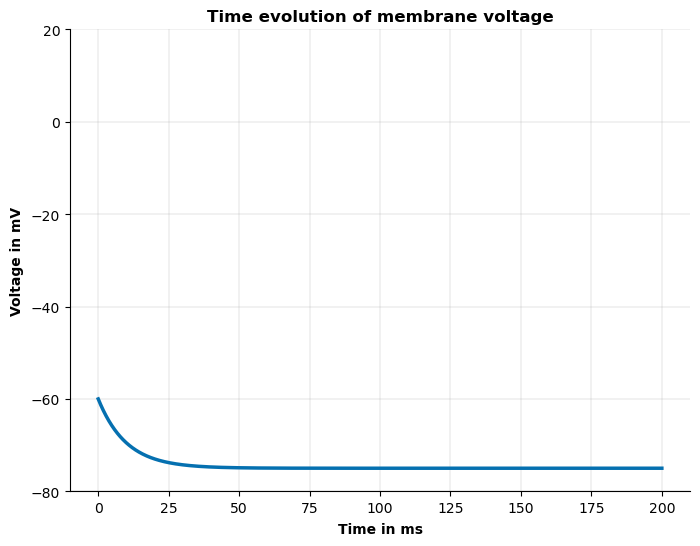

In [16]:
class LIFNeuron_AMPA(object):
    """A LIF neuron with the possibility to add AMPA inputs 
    the methods allow to run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 10, v_reset = -70, v_th = -50, I_e = 10e-8, dt = 0.1,
                g_ampa = 0.85):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron_AMPA, self).__init__()
        
        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.el = -75 # leak reversal potential
        
        self.r_m = 100e6 # membrane resistance
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_e = I_e # Input current
        
        
        self.v = -60 # starting voltage value for the simulation
        self.dt = dt # simulation timestep    
        
        
        ### Initiate the recording lists
        self.v_list = [self.v]
        self.t_list = [0]
        
        
        ### Initiate synaptic paramters
        ''' Code below '''
        
    
    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''            
        ### Time evolution of the synaptic input
        ''' Code below '''
            
            
        ### Time evolution of the membrane potential
        ''' You need to change some parts here as well'''
        if self.v <= self.v_th:
            dv_dt = (-self.v + self.el + self.r_m * self.I_e)/self.tau_m
            self.v += dv_dt * self.dt
        else:
            self.v = self.v_reset
            
    
    def run_simulation(self, time_steps = 100):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''
        
        for ii in range(time_steps):
            self.timestep()
            
            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])

        
def single_input():
    test = LIFNeuron_AMPA(I_e = 0, g_ampa = 0.85)
    test.run_simulation(1000)
    test.ampa_input = True
    test.run_simulation(1000)
    test.plot_traces()

single_input()

### [Solution 1](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/0b6d6a1ac53626e00xdee2ae7ca52865.txt)

### Task 2

Show the difference between the excitatory postsynaptic potential (EPSP) and the excitatory postsynaptic current (EPSC) and the excitatory postsynaptic conductance (EPSC)

To achieve this, you can use the same class you just created, you need to modify 

a) the values that you collect per timestep (at the moment its only t and v) we need to collect the current and the conductance as well and 
b) you need a new plotting function, call it 'plot_voltage_current_and_conductance'

To create three subplots (so that you can show all traces at once) you can use the following code (try it out in a new cell):

```python
fig, axes = plt.subplots(2)

x = np.linspace(0,10,100)
y = np.sin(x)
fig.suptitle('Vertically stacked subplots')
axes[0].plot(x, y)
axes[1].plot(x, -y)

axes[0].set(
    xlabel = 'Time in ms',
    ylabel = 'arbitraty units'
    )
axes[1].set(
    xlabel = 'Time in ms',
    ylabel = 'arbitraty units'
    )
plt.tight_layout() # This makes the plot cleaner, you can try how it looks if you remove this part
```

I already added the skeleton of the solution in the cell below.


In [24]:
class LIFNeuron_AMPA(object):
    """A LIF neuron with the possibility to add AMPA inputs 
    the methods allow to run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 10, v_reset = -70, v_th = -50, I_e = 10e-8, dt = 0.1,
                g_ampa = 0.85):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron_AMPA, self).__init__()
        
        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.el = -75 # leak reversal potential
        
        self.r_m = 100e6 # membrane resistance
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_e = I_e # Input current
        
        
        self.v = -60 # starting voltage value for the simulation
        self.dt = dt # simulation timestep    
        
        
        ### Initiate the recording lists
        self.v_list = [self.v]
        self.t_list = [0]
        
        
        ### Initiate synaptic paramters
        self.ps_ampa = 0 # when starting the simulations the channels should be closed
        self.ampa_input = False # and there is no input
        self.g_ampa = g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
        ''' add code here '''
        
    
    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''            
        ### Time evolution of the synaptic input
        if self.ampa_input == True:
            self.ps_ampa = 1 # if there is a spike in this time step, the channels open
            self.ampa_input = False # remove the input 
        else:
            dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
            self.ps_ampa += dps_ampa_dt * self.dt
            
        ### Time evolution of the membrane potential
        i_ampa = self.g_ampa*self.ps_ampa*(self.e_ampa-self.v)
        if self.v <= self.v_th:
            dv_dt = (-self.v + self.el + self.r_m * self.I_e + i_ampa)/self.tau_m
            self.v += dv_dt * self.dt
        else:
            self.v = self.v_reset
            
        ''' add code here '''
        
    def run_simulation(self, time_steps = 100):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''
        
        for ii in range(time_steps):
            self.timestep()
            
            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])
        
    def plot_voltage_current_and_conductance(self):
        '''
            Function to plot the simulated results
            creates a figure with 3 subplots and plots 
            voltage traces, current traces and conductance traces vs. the simulated time
        '''
        pass

        
def single_input():
    test = LIFNeuron_AMPA(I_e = 0, g_ampa = 0.85)
    test.run_simulation(1000)
    test.ampa_input = True
    test.run_simulation(1000)
    test.plot_voltage_current_and_conductance()

single_input() 

### [Solution 2](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/55fb97641ed9b37a13eed8e5a19f663a.txt)

### Task 3

Now we want to use our class to see how many inputs can lead to a spike of the cell. 
Can a single input make the cell spike? 
How strong does it need to be? 

can you make the cell spike with multiple inputs? 
How close in time do they have to be? 

Feel free to come up with your own implmentation, or you can have a look at the solution

In [ ]:
''' put your code in this cell'''




### [Solution 3](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/e9301038090326b69fb0b4d6c8c80217.txt)

### Task 4 

Add an inhibitory input to the class. 

The implementation follows exactly the implementation of the AMPA inputs. Now it's GABA

the paramters are:

``` python
    ps_gaba = 0 # when starting the simulations the channels should be closed
    gaba_input = False # and there is no input
    g_gaba = g_gaba # strength of synaptic input (we can define it when creating the class)
        
    e_gaba = -80 # reversal potential of the GABA channel
    tau_gaba = 8 # in ms
```

You also need to add the implementation in the timestep function

The function 'run_simulation' is already modified. In this way it allows for a more flexible way of handling mulitple inputs. 
There is also already an interactive function coded in the end, so that once you finished the implementation, you can investigate the impact of an inhibitory input onto the spiking behavior of a cell.


In [29]:
class LIFNeuron_AMPA_GABA(object):
    """The first version of our LIF neuron class that can initiate a single neuron, 
    run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 10, v_reset = -70, v_th = -50, I_e = 10e-8, dt = 0.1,
                g_ampa = 0.85, g_gaba = 0.85):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron_AMPA_GABA, self).__init__()
        
        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.el = -75 # leak reversal potential
        
        self.r_m = 100e6 # membrane resistance
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_e = I_e # Input current
        
        
        self.v = -60 # starting voltage value for the simulation
        self.dt = dt # simulation timestep    
        
        
        ### Initiate the recording lists
        self.v_list = [self.v]
        self.t_list = [0]
        
        
        ### Initiate synaptic paramters
        self.ps_ampa = 0 # when starting the simulations the channels should be closed
        self.ampa_input = False # and there is no input
        self.g_ampa = g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
        ''' add parameters here '''
        
        
        self.i_ampa_list = [0]
        self.g_ampa_list = [0]
    
    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        ### Time evolution of the synaptic input
        if self.ampa_input == True:
            self.ps_ampa = 1 # if there is a spike in this time step, the channels open
            self.ampa_input = False # remove the input 
        else:
            dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
            self.ps_ampa += dps_ampa_dt * self.dt
            
        ''' add code here '''
            
        ### Time evolution of the membrane potential
        i_ampa = self.g_ampa*self.ps_ampa*(self.e_ampa-self.v)
        ''' add code here  '''
        if self.v <= self.v_th:
            ''' modify the code here '''
            dv_dt = (-self.v + self.el + self.r_m * self.I_e + i_ampa)/self.tau_m
            self.v += dv_dt * self.dt
        else:
            self.v = self.v_reset
            
    
        self.i_ampa_list.append(i_ampa)
        self.g_ampa_list.append(self.g_ampa * self.ps_ampa)
    
    
    def run_simulation(self, 
                       time_steps = 100,
                       ampa_inputs = [],
                       gaba_inputs = []):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
            We can define synaptic events as time_steps in a list.
            either exitatory (ampa_inputs) or inhibitory (gaba_inputs)
        '''
        
        for ii in range(time_steps):
            
            # we can check whether our current timestep is in the list of inputs we provide
            if ii in ampa_inputs:
                self.ampa_input = True
            
            if ii in gaba_inputs:
                self.gaba_input = True
            
            self.timestep()
            
            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])
    
    def plot_voltage_current_and_conductance(self):
        '''
            Function to plot the simulated results
            creates a figure with 3 subplots and plots 
            voltage traces, current traces and conductance traces vs. the simulated time
        '''
        fig, axes = plt.subplots(3)
        fig.suptitle('Comparison of excitatory postsynaptic voltage, current, and conductance')
        axes[0].plot(self.t_list,self.v_list,linewidth=2.5)
        axes[1].plot(self.t_list,self.i_ampa_list,linewidth=2.5)
        axes[2].plot(self.t_list,self.g_ampa_list,linewidth=2.5)

        axes[0].set(
            xlabel = 'Time in ms',
            ylabel = 'Voltage in mV'
            )
        axes[1].set(
            xlabel = 'Time in ms',
            ylabel = 'Current in micro A'
            )
        axes[2].set(
            xlabel = 'Time in ms',
            ylabel = 'Conductance in nS'
            )
        plt.tight_layout() # This makes the plot cleaner, you can try how it looks if you remove this part
        
        
def run_and_plot(I_e, gaba_input_timestep):
    neuron = LIFNeuron_AMPA_GABA(I_e = I_e*1e-8, g_ampa = 0.85, g_gaba = 0.8)
    neuron.run_simulation(2000, 
                        ampa_inputs = [1000, 1050, 1100],
                       gaba_inputs = [gaba_input_timestep],
                       )
    neuron.plot_traces()
    
    
    # reading out the time and voltage value so that the arrow points to the plot
    # If you don't know how to access an element in the list, feel free to ask
    x_input = neuron.t_list[gaba_input_timestep] 
    y_input = neuron.v_list[gaba_input_timestep]
    
    # use the annotate function to plot an arrow and the text 'GABA input'
    plt.annotate('GABA input', xy =(x_input, y_input),
                xytext =(x_input-40, y_input + 20), 
                arrowprops = dict(arrowstyle='->',facecolor ='#CC1414', edgecolor='#CC1414',
                                  shrinkA = 0.1))

interact(run_and_plot,I_e = 5, gaba_input_timestep=(700,1150,10))

interactive(children=(IntSlider(value=5, description='I_e', max=15, min=-5), IntSlider(value=920, description=…

<function __main__.run_and_plot(I_e, gaba_input_timestep)>

### [Solution 4](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/dc08a6dbb265e55110b411903611e3ab.txt)

### Task 5

Implement a multi-compartment model. 

We now re-write our class again, so that we can use it to describe the voltage value within distinct compartments. 
We can then later use this class to couple multiple compartments together. 
Remember from the lecture how the coupling is implemented: 

\begin{equation}
c_m \frac{dV_{\mu}}{dt} = -i^{\mu}_m + \frac{I_e^{\mu}}{A_{\mu}} + g_{\mu, \mu+1} \left(V_{\mu + 1} - V_{\mu}\right) + g_{\mu, \mu - 1}\left(V_{\mu - 1} - V_{\mu}\right)
\end{equation}

we now name our relevant parameters

```python
v_end_a # voltage value of the previous compartment
v_end_b # voltage value of the next compartment
g_end_a # conductance value of the previouse compartment 
g_end_b # conductance value of the next compartment
```




In [38]:
class LIFComp_AMPA_GABA(object):
    """The first version of our LIF neuron class that can initiate a single neuron, 
    run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 10, v_reset = -70, v_th = -50, I_e = 10e-8, dt = 0.1,
                g_ampa = 0.85, g_gaba = 0.85,
                 g_end_a = 0.5, g_end_b = 0.5,
                 can_spike = True):
        '''This function is executed when we create an object from that class'''
        super(LIFComp_AMPA_GABA, self).__init__()
        
        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.el = -75 # leak reversal potential
        
        self.r_m = 100e6 # membrane resistance
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_e = I_e # Input current
        
        
        self.v = -60 # starting voltage value for the simulation
        self.dt = dt # simulation timestep    
        
        
        ### Initiate the recording lists
        self.v_list = [self.v]
        self.t_list = [0]        
        
        ### Initiate synaptic paramters
        self.ps_ampa = 0 # when starting the simulations the channels should be closed
        self.ampa_input = False # and there is no input
        self.g_ampa = g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
        self.ps_gaba = 0 # when starting the simulations the channels should be closed
        self.gaba_input = False # and there is no input
        self.g_gaba = g_gaba # strength of synaptic input
        
        self.e_gaba = -80 # reversal potential of the GABA channel
        self.tau_gaba = 8 # in ms
        
        
        ### Initiate neighbour parameters
        ''' put your code here'''
        
        self.can_spike = can_spike
        
        
    
    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        ### Time evolution of the synaptic input
        if self.ampa_input == True:
            self.ps_ampa = 1 # if there is a spike in this time step, the channels open
            self.ampa_input = False # remove the input 
        else:
            dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
            self.ps_ampa += dps_ampa_dt * self.dt
            
        if self.gaba_input == True:
            self.ps_gaba = 1 # if there is a spike in this time step, the channels open
            self.gaba_input = False # remove the input 
        else:
            dps_gaba_dt = -self.ps_gaba / (self.tau_gaba) # The channels close with an exponential decay
            self.ps_gaba += dps_gaba_dt * self.dt
            
        ### Time evolution of the membrane potential
        i_ampa = self.g_ampa*self.ps_ampa*(self.e_ampa-self.v)
        i_gaba = self.g_gaba*self.ps_gaba*(self.e_gaba-self.v)
        
        '''  you need to add some code here'''
        
        
        
        if self.v <= self.v_th or not self.can_spike:
            ''' you need to modify this equation '''
            dv_dt = (-self.v + self.el + self.r_m * self.I_e + i_ampa + i_gaba )/self.tau_m
            self.v += dv_dt * self.dt
        else:
            self.v = self.v_reset
            
    
    def run_simulation(self, 
                       time_steps = 100,
                       ampa_inputs = [],
                       gaba_inputs = []):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
            We can define synaptic events as time_steps in a list.
            either exitatory (ampa_inputs) or inhibitory (gaba_inputs)
        '''
        
        for ii in range(time_steps):
            
            # we can check whether our current timestep is in the list of inputs we provide
            if ii in ampa_inputs:
                self.ampa_input = True
            
            if ii in gaba_inputs:
                self.gaba_input = True
            
            self.timestep()
            
            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 

### [Solution 5](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_2/solutions/e9301038094966b69fb04ff6c8c80217.txt)

### Task 6

Now we construct a two-compartment model. 
Try to understand the code and answer the following questions when you run it

Does it make sense that for one input the soma spikes and for the other it doesn't?

What are the differences between the postysnaptic potentials in the soma and the dendrite when the input arrives at the dendrite? 

In [50]:
# Constructing a two-compartment model

g_couple_soma_dendrite = 0.4
g_couple_dendrite_soma = 1.2

soma = LIFComp_AMPA_GABA(g_end_a = 0, g_end_b = g_couple_soma_dendrite, can_spike=True, g_ampa = 1.25)
dend = LIFComp_AMPA_GABA(g_end_a = g_couple_dendrite_soma, g_end_b = 0, can_spike=False, g_ampa = 1.25)

# now we run the simulation
for ii in range(1200):

    # we first need to set the voltage value of the neighbour compartments
    soma.v_end_b = dend.v
    dend.v_end_a = soma.v

    # now we run the timestep 
    soma.timestep()
    dend.timestep()


    # add the current values to the lists of the compartments
    soma.v_list.append(soma.v)
    dend.v_list.append(dend.v)
    current_time = soma.t_list[-1] + soma.dt
    soma.t_list.append(current_time) 
    dend.t_list.append(current_time) 
    
    
    if ii == 400:
        dend.ampa_input = True
        
    if ii == 800:
        soma.ampa_input = True

plt.figure()
plt.title('Time evolution of membrane voltage')
plt.plot(soma.t_list,soma.v_list,linewidth=1.5, label = 'Soma')
plt.plot(dend.t_list,dend.v_list,linewidth=1.5, label = 'Dendrite')
plt.xlabel('Time in ms')
plt.ylabel('Voltage in mV')
plt.ylim([-80,20])

plt.legend()

### Task 7 

We now (very rudimentary) try to replicate the result from Rall, that dendrites can detect whether synaptic inputs arrive directed towards the soma or away from it. 
<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_2/static/rall_result.png" width="750"/>
</div>

Therefore we create a multi-compartment model with four dendritic units and apply a sequence of inputs to these compartments.

you can run the cell below to 'run the experiment'

In [48]:

# create the neuron

def construct_and_run_multicompartment(delta_inputs = 100, g_ampa = 0.8, g_couple = 0.8, n_inputs = 4):
    # first the soma
    soma = LIFComp_AMPA_GABA(g_end_a = 0, g_end_b = g_couple * 0.5, can_spike=True, g_ampa = g_ampa)
    dend_1 = LIFComp_AMPA_GABA(g_end_a = g_couple * 2, g_end_b = g_couple, can_spike=False, g_ampa = g_ampa)
    dend_2 = LIFComp_AMPA_GABA(g_end_a = g_couple, g_end_b = g_couple, can_spike=False, g_ampa = g_ampa)
    dend_3 = LIFComp_AMPA_GABA(g_end_a = g_couple, g_end_b = g_couple, can_spike=False, g_ampa = g_ampa)
    dend_4 = LIFComp_AMPA_GABA(g_end_a = g_couple, g_end_b = 0, can_spike=False, g_ampa = g_ampa)

    all_compartments = [soma, dend_1, dend_2, dend_3, dend_4]

    # now we run the simulation
    for ii in range(1200):


        # we transfer every neighbouring voltage
        for jj, comp in enumerate(all_compartments):

            aa = jj - 1
            bb = jj + 1

            if aa >= 0:
                comp_a = all_compartments[aa]
                comp.v_end_a = comp_a.v

            if bb <= len(all_compartments) - 1:
                comp_b = all_compartments[bb]
                comp.v_end_b = comp_b.v

        # now we run one timestep for every compartment
        for comp in all_compartments:
            comp.timestep()

            comp.v_list.append(comp.v)
            current_time = comp.t_list[-1] + comp.dt
            comp.t_list.append(current_time) 

        if ii == 450 and n_inputs > 3:
            all_compartments[4].ampa_input = True
            
        if ii == 450 + delta_inputs and n_inputs > 2:
            all_compartments[3].ampa_input = True  
        
        if ii == 450 + 2 * delta_inputs and n_inputs > 1:
            all_compartments[2].ampa_input = True  
            
        if ii == 450 + 3 * delta_inputs and n_inputs > 0:
            all_compartments[1].ampa_input = True  
            
    plt.figure()
    plt.title('Time evolution of membrane voltage')
    
    for comp, name in zip(all_compartments, ['soma','dend 1', 'dend 2', 'dend 3', 'dend 4']):
        plt.plot(comp.t_list,comp.v_list,linewidth=1.5, label = name)
        
    plt.xlabel('Time in ms')
    plt.ylabel('Voltage in mV')
    plt.ylim([-80,20])
    
    plt.legend()

interact(construct_and_run_multicompartment, 
         delta_inputs = (-100, 100, 100), 
         g_ampa = (0.5, 40, 2), 
         g_couple = (0.5, 5, 0.1),
         n_inputs = (0,4,1))
    




interactive(children=(IntSlider(value=100, description='delta_inputs', min=-100, step=100), FloatSlider(value=…

<function __main__.construct_and_run_multicompartment(delta_inputs=100, g_ampa=0.8, g_couple=0.8, n_inputs=4)>